<a href="https://colab.research.google.com/github/wafer110/Python-DataMining-MachineLearning/blob/master/HW2_WeiHuaHsu_(using_subdata).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Packages  

- Some packages may need to be installed first

In [ ]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import re

# Ignore warnings
import warnings; warnings.filterwarnings("ignore")

# Natural Language Processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stopWords = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec 

# Machine Learning
from sklearn.model_selection import train_test_split
# Stratified K-fold Cross Validation
from sklearn.model_selection import StratifiedKFold
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
# Evaluate Classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, accuracy_score
# Friedman & Nemenyi test
import scipy.stats as ss
!pip install scikit_posthocs
import scikit_posthocs as sp
# Clusters
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# Evaluate Clustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# UMAP
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
import umap
import umap.plot

## Read Data sets  

In [ ]:
# Read the data through github raw data URL
# Anyone with this .ipynb file can run it well
genuine_url = 'https://raw.githubusercontent.com/wafer110/Python-DataMining-MachineLearning/master/HW2/2020-03-13_1_coronavirus_genuine.xlsx'
genuine = pd.read_excel(genuine_url)
mixmisinfo_url = 'https://raw.githubusercontent.com/wafer110/Python-DataMining-MachineLearning/master/HW2/2020-03-13_10_coronavirus_misinformation.xlsx'
mixmisinfo = pd.read_excel(mixmisinfo_url)

In [ ]:
# Create a new column named 'labels'
# Genuine class = 0, Mixed Misinformed class = 1
genuine['labels'] = 0
mixmisinfo['labels'] = 1
# Combine two data sets into one S data set
S = pd.concat([genuine, mixmisinfo]).reset_index(drop = True)
S.head(3) # View the data

,id,source.text,labels
0,1237495776517009410,COVID-19 Update\nhttps://t.co/zVUNZqFp9x\n#Cor...,0
1,1237451958803484672,The Vox guide to Covid-19 coronavirus https:/...,0
2,1236041601157300225,The Vox guide to Covid-19 coronavirus https:/...,0


## Data Pre-processing

### Detect language  
   
- (Running this commend will take a bit while.)   
- The original size of Genuine is 128003 and Mix_misinformation is 1614. I omitted non-English tweets in order to do a better further analysis. The size of new subset data is 125633 + 1612 = 127245 observations.    
- Reference:   
https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language   


In [ ]:
# Language Detect (download pkg required)
!pip install langdetect
from langdetect import detect, DetectorFactory

In [ ]:
# Detect the language from each tweet
# Keep the English tweet only
DetectorFactory.seed = 0
S['language'] = S['source.text'].apply(detect)
S = S[S['language'] == 'en']
# Reset index
S = S.reset_index(drop = True)
# Review the data set
S.shape

(127245, 4)

### Text Cleaning  
  
- In this part, I cleaned the text by removing `twitter handles`, `Internet domains`, and `punctuations`. I also remove `short tweets` at which text length is shorter than 3. The size of clened dataset has **126879** observations.

In [ ]:
def CleanText(text):
  # Replace contractions
  text = text.replace("’", "'")
  text = text.replace("can't", "can not")
  text = text.replace("won't", "will not")
  text = text.replace("n\'t", " not")
  text = text.replace("\'ll", " will")
  text = text.replace("\'ve", " have")
  text = text.replace("\'d", " would")
  text = text.replace("\'s", " is") 
  text = text.replace("\'m", " am")
  text = text.replace("\'re", " are")
  text = text.replace("\n", " ")
  # Remove twitter handles 
  output = re.sub("@[\w]*", "", text)
  # Remove Internet domains
  output = re.sub("http\S+", "", output)
  # Remove punctuations
  output = re.sub("[^a-zA-Z0-9\s]", "", output)
  # Remove extra whitepaces
  output = re.sub("\s+", " ", output)
  return(output)

# Apply function "CleanText"
S['texts'] = S['source.text'].apply(CleanText)
# Lowercase the tweets
S['texts'] = S['texts'].apply(str.lower)
# Remove short tweets (length < 3)
S['text_length'] = [len(S['texts'][i].split()) for i in range(len(S['texts']))]
S = S[S['text_length'] > 3][['id', 'texts', 'labels', 'source.text']] 

- In addition to preliminary text cleaning process. This part applied the data to a couple of important and useful NLP manipulating terms. Including `tokenize`, `lemmatize`, and `remove stopwords`.

In [ ]:
def ProcessText(text): 
  output = [word for word in text.split() if word not in stopWords]
  output = [lemmatizer.lemmatize(w) for w in word_tokenize(" ".join(output))]
  output = " ".join(output)
  return(output)

# Apply function "ProcessText"
S['texts'] = S['texts'].apply(ProcessText)
# Reset index
S = S.reset_index(drop = True)
# Review the data set
S.head(3)

,id,texts,labels,source.text
0,1237495776517009410,covid19 update coronavirus covid19,0,COVID-19 Update\nhttps://t.co/zVUNZqFp9x\n#Cor...
1,1237451958803484672,vox guide covid19 coronavirus covid19 coronavirus,0,The Vox guide to Covid-19 coronavirus https:/...
2,1236041601157300225,vox guide covid19 coronavirus covid19 coronavirus,0,The Vox guide to Covid-19 coronavirus https:/...


Reference:    
  
Text Cleaning + Classifiers https://medium.com/analytics-vidhya/twitter-sentiment-analysis-b9a12dbb2043    
Pre-processing https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

### Pre-train Model  
  
- Convert the data into features in order to fit the classifiers. This assignment will cover TF-IDF and Word Embeddings.   
  
- I copied the `S` dataset as `S_set` to keep the original dataset S for other uses.

In [114]:
S_set = S
S_set.shape

(126879, 4)

#### TF-IDF (Subset Data)

In [224]:
tfidf_vec = TfidfVectorizer(max_df = 0.80, min_df = 5, max_features = 2000) 
tfidf_array = tfidf_vec.fit_transform(S['texts'])
tfidf_df = pd.DataFrame(tfidf_array.toarray())
# Review the TF-IDF vector
tfidf_df.shape

(126879, 2000)

In [32]:
# Obtain a subset TF-IDF vector & S set
tfidf_df = tfidf_df.iloc[120000:, :].reset_index(drop = True)
S_set = S.iloc[120000:].reset_index(drop = True)
# Review the shape of TF-IDF vector & Labels
print(tfidf_df.shape, S_set.labels.shape)
print('The S set dataset is trimmed to', S_set.shape)

(6879, 2000) (6879,)
The S set dataset is trimmed to (6879, 4)


#### Word2vec   
 
Word2vec is a two-layer neural net that processes text. Its input is a text corpus and its output is a set of vectors.  
  
Reference:   
https://realpython.com/python-keras-text-classification/#word-embeddings

In [ ]:
# Tokenize texts for fitting to the w2v 
texts_token = S['texts'].apply(lambda x: x.split()) 

# Word2Vec - skip-gram model
model_w2v = Word2Vec(texts_token, 
                     size = 200,  # desired number of features/independent variables 
                     window = 5, # context window size 
                     min_count = 2, 
                     sg = 1, # skip-gram model 
                     hs = 0, 
                     negative = 10, # negative sampling 
                     workers = 2, # number of cores 
                     seed = 34)
model_w2v.train(texts_token, total_examples = len(S['texts']), epochs = 20)

In [ ]:
# most_similar words
model_w2v.wv.most_similar(positive = 'trump')
model_w2v.wv.most_similar(positive = 'covid19')
model_w2v.wv.most_similar(positive = 'pandemic')

[('pand', 0.5039507150650024),
 ('finallycoronavirus', 0.4961145520210266),
 ('directorate', 0.48065871000289917),
 ('dotarddonnie', 0.4786580801010132),
 ('pandemi', 0.46463823318481445),
 ('thoughtsandprayers', 0.46440640091896057),
 ('dementiadonnie', 0.46411222219467163),
 ('announc', 0.45796287059783936),
 ('wuhanvirus2020', 0.45591285824775696),
 ('rung', 0.4537968933582306)]

- Set a function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [ ]:
def word_vector(tokens, size): 
  vec = np.zeros(size).reshape((1, size)) 
  count = 0.
  for word in tokens: 
    try: 
      vec += model_w2v[word].reshape((1, size)) 
      count += 1.
    except KeyError:  # when token is not in vocabulary
      continue 
  if count != 0:
    vec /= count 
  return(vec)

- Prepared a Word2Vec feature set.

In [ ]:
w2v_arrays = np.zeros((len(texts_token), 200))

for i in range(len(texts_token)): 
  w2v_arrays[i,:] = word_vector(texts_token[i], 200)
  
w2v_df = pd.DataFrame(w2v_arrays) 
w2v_df.shape

# Part I

## Classification    

- The procedure of fit the classifiers includes **1) K-fold CV; 2) classifiers; and 3) evaluation**.   
  
- Reference:   
Kfold CV https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/  
Cross_val_score https://stackoverflow.com/questions/16379313/how-to-use-the-a-k-fold-cross-validation-in-scikit-with-naive-bayes-classifier-a  
Cross_val_score Keys https://scikit-learn.org/stable/modules/model_evaluation.html

### 1) K-fold Cross Validation  

- To fit the K-fold cross validation, I used Stratified K-fold Cross Validation. It is because Stratified K-fold will divide data into 10 folds with the same proportion.

In [47]:
# Stratified K-fold CV
SKfold = StratifiedKFold(n_splits = 10, random_state = 29, shuffle = True)

### 2) Fit Classifiers

#### Decision Tree


In [48]:
%%time
# Fit Decision Tree Classifier
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 50)

# Evaluation
DT_precision = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                               scoring = 'precision')
DT_recall = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                            scoring = 'recall')
DT_f1 = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                        scoring = 'f1')

# Print the results
print(f'Precision: {np.mean(DT_precision)}')
print(f'Recall: {np.mean(DT_recall)}')
print(f'F-Measure: {np.mean(DT_f1)}')

Precision: 0.9066270793069808
Recall: 0.926830764511924
F-Measure: 0.9160865200457156
CPU times: user 22.3 s, sys: 377 ms, total: 22.7 s
Wall time: 22.7 s


#### Multi-layer Preceptrons

In [68]:
%%time
# Fit Multi-Layer Perceptrons 
clf = MLPClassifier(activation = 'logistic', 
                    alpha = 1e-5,
                    max_iter = 1000,  
                    random_state = 1,
                    learning_rate_init = 0.5)

# Evaluation
MLP_precision = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                                scoring = 'precision')
MLP_recall = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                             scoring = 'recall')
MLP_f1 = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                         scoring = 'f1')

# Print the results
print(f'Precision: {np.mean(MLP_precision)}')
print(f'Recall: {np.mean(MLP_recall)}')
print(f'F-Measure: {np.mean(MLP_f1)}')

Precision: 0.900960648937275
Recall: 0.8802737520128824
F-Measure: 0.8900577645703294
CPU times: user 9min 41s, sys: 8min 27s, total: 18min 9s
Wall time: 4min 37s


#### Naive Bayes

Different Naive Bayes classifiers provide different algorithms which depend on the feature data (training data = input data = X). The difference of NB classifiers are sorted below:    

1. **Gaussian NB**: It should be used for the features in decimal form. Gaussian NB assumes features to follow a normal distribution.  

2. **MultiNomial NB**: It should be used for the features with discrete values like word count 1,2,3, etc.

3. **Bernoulli NB**: It should be used for features with binary or boolean values like True/False or 0/1.

- As for this Covid-19 Tweets, I tried with all above NB methods. The `Bernoulli Naive Bayes` performs the best with f1 = 0.88.   
- Concerning to too long codes, I didn't print all NB classifiers results but I hashtag the classifier commend and pasted the evaluation results afterwards.

In [72]:
# Fit Naive Bayes Classifier
# (You may un-hashtag the classifiers to 
#  compare the performance between different NB classifiers)
clf = BernoulliNB()    
#clf = GaussianNB()    
#clf = MultinomialNB() 

# Evaluation
NB_precision = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                               scoring = 'precision')
NB_recall = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                            scoring = 'recall')
NB_f1 = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                        scoring = 'f1')

# Print the results
print(f'Precision: {np.mean(NB_precision)}')
print(f'Recall: {np.mean(NB_recall)}')
print(f'F-Measure: {np.mean(NB_f1)}')

Precision: 0.8650397146591043
Recall: 0.9088183421516755
F-Measure: 0.8862884377863345


#### K-Nearest Neighbors   

In [75]:
%%time

kNN_precision = []
kNN_recall = []
kNN_f1 = []

for train_index, test_index in SKfold.split(tfidf_df, S_set.labels):
  X_train, X_test = tfidf_df.iloc[train_index,:], tfidf_df.iloc[test_index,:]
  y_train, y_test = S_set.labels[train_index], S_set.labels[test_index]
  
  # Fit Classifier
  clf = KNeighborsClassifier(n_neighbors = 2)    
  # Train the model using the training sets
  clf.fit(X_train,y_train)
  # Predict Output
  y_pred = clf.predict(X_test)
  
  # Evaluation
  Precisions = precision_score(y_test, y_pred)
  kNN_precision.append(Precisions)
  Recalls = recall_score(y_test, y_pred)
  kNN_recall.append(Recalls)
  F_Measures = f1_score(y_test, y_pred)
  kNN_f1.append(F_Measures)


print(f'Precision: {np.mean(kNN_precision)}')
print(f'Recall: {np.mean(kNN_recall)}')
print(f'F-Measure: {np.mean(kNN_f1)}')

Precision: 0.9545462202040211
Recall: 0.5656391381029062
F-Measure: 0.7052383903643774
CPU times: user 2min 42s, sys: 6.17 ms, total: 2min 42s
Wall time: 2min 42s


#### Support Vector Machines (SVM)  
  
- The Kernel SVM is similar to the simple SNM, but the kernal SVM can use Gaussian, polynomial, sigmoid, or computable kernel.   
  
- I implement simple SVM cause the simple (linear) one help reduce the very too large computing burdens, and the performance I tried does return better than Gaussian or other Kernal SVM.

In [79]:
%%time

SVM_precision = []
SVM_recall = []
SVM_f1 = []

for train_index, test_index in SKfold.split(tfidf_df, S_set.labels):
  X_train, X_test = tfidf_df.iloc[train_index,:], tfidf_df.iloc[test_index,:]
  y_train, y_test = S_set.labels[train_index], S_set.labels[test_index]
  
  # Fit Classifier
  clf = SVC(kernel = 'linear', gamma = 'auto', random_state = 13)
  # Train the model using the training sets
  clf.fit(X_train,y_train)
  # Predict Output
  y_pred = clf.predict(X_test)
  
  # Evaluation
  Precisions = precision_score(y_test, y_pred)
  SVM_precision.append(Precisions)
  Recalls = recall_score(y_test, y_pred)
  SVM_recall.append(Recalls)
  F_Measures = f1_score(y_test, y_pred)
  SVM_f1.append(F_Measures)

print(f'Precision: {np.mean(SVM_precision)}')
print(f'Recall: {np.mean(SVM_recall)}')
print(f'F-Measure: {np.mean(SVM_f1)}')

Precision: 0.9160302608192825
Recall: 0.9373667663522735
F-Measure: 0.926434070308986
CPU times: user 4min 3s, sys: 25.5 ms, total: 4min 3s
Wall time: 4min 3s


#### Bagging  

- In Bagging algorithm, the number of decision trees used is an important parameter. Usually, the number of trees is increased until the model performance becomes stable. The natural of this learning algorithm is immune to overfitting when more trees is tuned. The number of trees can be set via "n_estimators", the default setting is 100.  

In [84]:
%%time 

# Fit Bagging
clf = BaggingClassifier(max_samples=0.5, bootstrap=False)

# Evaluation
Bag_precision = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                                scoring = 'precision')
Bag_recall = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                             scoring = 'recall')
Bag_f1 = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                         scoring = 'f1')

# Print the results
print(f'Precision: {np.mean(Bag_precision)}')
print(f'Recall: {np.mean(Bag_recall)}')
print(f'F-Measure: {np.mean(Bag_f1)}')

Precision: 0.9074754405542726
Recall: 0.9249674104746568
F-Measure: 0.9183167223570059
CPU times: user 2min 8s, sys: 1.56 s, total: 2min 10s
Wall time: 2min 10s


#### Boosting  
  
- In addition to focus on high quality prediction as most Machine Learning models do so, boosting algorithms aim to improve the prediction power by training a sequence of weak model. Each model compensates the weaknesses of its predecessors.   
- Among boosting algorithms, I tried `Gradient Boosting Regressor` and `Ada Boost Classifier`. The performance in Ada Boost is valid while the Gradient can't be fitted properly since the Gradient is a non-parametric statistical learning technique.  

In [87]:
%%time 

# Fit Boosting
clf = AdaBoostClassifier(random_state=1) # n_estimators=100, learning_rate = 0.5

# Evaluation
Bst_precision = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                                scoring = 'precision')
Bst_recall = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                             scoring = 'recall')
Bst_f1 = cross_val_score(clf, tfidf_df, S_set.labels, cv = SKfold, 
                         scoring = 'f1')

# Print the results
print(f'Precision: {np.mean(Bst_precision)}')
print(f'Recall: {np.mean(Bst_recall)}')
print(f'F-Measure: {np.mean(Bst_f1)}')

Precision: 0.9431285974596051
Recall: 0.9044973544973545
F-Measure: 0.9230999539605923
CPU times: user 2min 47s, sys: 112 ms, total: 2min 47s
Wall time: 2min 47s


Reference:     
  
Naive Bayes https://stats.stackexchange.com/questions/258458/bernoulli-nb-vs-multinomial-nb-how-to-choose-among-different-nb-algorithms  
kNN https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/     
SBM https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/    
Bagging https://machinelearningmastery.com/bagging-ensemble-with-python/  
Ada Boost Classifier https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier   
Boosting https://towardsdatascience.com/boosting-algorithms-explained-d38f56ef3f30  
Define Overfitting https://shankarmsy.github.io/stories/gbrt-sklearn.html    

### 3) Evaluation    
  
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. This evaluation methods are typically used in binary classification to study the output of a classifier.   
   
High scores for precision and recall show that the classifier is returning accurate results (high precision), as well as a majority of all positive results (high recall).

Besides, the F1-Measure can be interpreted as a weighted average of the precision and recall. When F1-Measure reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1-Measure are equal.  

The situation of `high recall but low precision` returns many results, but most of its predicted labels are incorrect when compared to the training labels. While a system with `high precision but low recall` is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. The ideal system with high precision and high recall will return many results, with all results labeled correctly.

#### Precision  
  
The precision is a measure of result relevancy.



In [167]:
Precisions = pd.DataFrame([DT_precision, MLP_precision, NB_precision, kNN_precision,
                           SVM_precision, Bag_precision, Bst_precision],
                          index = ['DT', 'MLP', 'NB', 'kNN', 'SVM', 'Bag', 'Bst'])
# A table of precisions with 7 classifiers in 10-folds
Precisions.transpose()

,DT,MLP,NB,kNN,SVM,Bag,Bst
0,0.918429,0.894410,0.890909,0.730769,0.913580,0.914110,0.905660
1,0.907463,0.891641,0.881459,0.627119,0.933333,0.913433,0.905660
2,0.921212,0.913580,0.913433,0.748092,0.933735,0.924471,0.931250
3,0.896142,0.866873,0.845921,0.703125,0.909639,0.892857,0.919255
4,0.920732,0.895899,0.892308,0.693227,0.922118,0.907407,0.940063
5,0.928793,0.910769,0.900302,0.698039,0.938650,0.932099,0.934579
6,0.919753,0.873786,0.893617,0.650407,0.935780,0.923547,0.917722
7,0.905063,0.885449,0.869822,0.674699,0.910769,0.916409,0.916667
8,0.918750,0.890282,0.889571,0.841424,0.925926,0.925926,0.928105
9,0.924528,0.877888,0.885542,0.685484,0.940810,0.932907,0.932039


- According to the `Friedman's test` for Precisions, the p-value = 1.68e-08 is very small. We have sufficient evidence to reject the null hypothesis that different classifiers have the same precisions.

In [179]:
# Transpose the matrix to be 7 classifiers by 10-folds
print(*np.array(Precisions).shape)
# Friedman test
ss.friedmanchisquare(*np.array(Precisions))

FriedmanchisquareResult(statistic=47.225806451612925, pvalue=1.6867799453547035e-08)

- The `Nemenyi multiple comparison test` identifies the difference between classifiers. The relationships between these classifiers are highly significant (p-value < 0.01):    
  - K-Nearest Neighbors v.s. Decision Trees, MLP, NB, and Bagging;   
  - Boosting v.s. Decision Trees, MLP, and Naive Bayes.    




In [180]:
# Nemenyi test
sp.posthoc_nemenyi_friedman(Precisions.transpose())

,DT,MLP,NB,kNN,SVM,Bag,Bst
DT,1.000000,0.900000,0.254909,0.011348,0.686522,0.900000,0.042827
MLP,0.900000,1.000000,0.309857,0.007884,0.625655,0.900000,0.031341
NB,0.254909,0.309857,1.000000,0.001000,0.002458,0.165019,0.001000
kNN,0.011348,0.007884,0.001000,1.000000,0.503923,0.022624,0.900000
SVM,0.686522,0.625655,0.002458,0.503923,1.000000,0.808251,0.747387
Bag,0.900000,0.900000,0.165019,0.022624,0.808251,1.000000,0.076892
Bst,0.042827,0.031341,0.001000,0.900000,0.747387,0.076892,1.000000


#### Recall  
  
Recall is a measure of how many truly relevant results are returned.

In [176]:
Recalls = pd.DataFrame([DT_recall, MLP_recall, NB_recall, kNN_recall,
                        SVM_recall, Bag_recall, Bst_recall],
                       index = ['DT', 'MLP', 'NB', 'kNN', 'SVM', 'Bag', 'Bst'])
# A table of recalls with 7 classifiers in 10-folds
Recalls.transpose()

,DT,MLP,NB,kNN,SVM,Bag,Bst
0,0.956522,0.894410,0.913043,0.590062,0.919255,0.944099,0.894410
1,0.950311,0.894410,0.900621,0.459627,0.956522,0.962733,0.894410
2,0.931677,0.919255,0.950311,0.608696,0.962733,0.944099,0.925466
3,0.931677,0.869565,0.869565,0.559006,0.937888,0.931677,0.919255
4,0.925466,0.881988,0.900621,0.540373,0.919255,0.906832,0.925466
5,0.931677,0.919255,0.925466,0.552795,0.950311,0.944099,0.931677
6,0.931677,0.838509,0.913043,0.496894,0.950311,0.906832,0.900621
7,0.895062,0.882716,0.907407,0.518519,0.913580,0.901235,0.882716
8,0.907407,0.876543,0.895062,0.802469,0.925926,0.901235,0.876543
9,0.906832,0.826087,0.913043,0.527950,0.937888,0.906832,0.894410


- The Friedman's test in Recalls, it is significant to reject the null hypothesis that different classifiers have the same recall with a very small p-value = 1.32e-08.

In [181]:
# Friedman test
ss.friedmanchisquare(*np.array(Recalls))

FriedmanchisquareResult(statistic=47.7495462794918, pvalue=1.3258895535557776e-08)

- The Nemenyi multiple comparison test identifies the kNN to Decision Trees, Naive Bayes, SVM, and Bagging are strongly significant (p-value < 0.01).

In [182]:
# Nemenyi test
sp.posthoc_nemenyi_friedman(Recalls.transpose())

,DT,MLP,NB,kNN,SVM,Bag,Bst
DT,1.000000,0.026662,0.900000,0.001000,0.869118,0.900000,0.438420
MLP,0.026662,1.000000,0.309857,0.838686,0.001000,0.036707,0.899551
NB,0.900000,0.309857,1.000000,0.009472,0.281728,0.900000,0.900000
kNN,0.001000,0.838686,0.009472,1.000000,0.001000,0.001000,0.165019
SVM,0.869118,0.001000,0.281728,0.001000,1.000000,0.808251,0.022624
Bag,0.900000,0.036707,0.900000,0.001000,0.808251,1.000000,0.503923
Bst,0.438420,0.899551,0.900000,0.165019,0.022624,0.503923,1.000000


#### F1-Measure

In [173]:
F1_scores = pd.DataFrame([DT_f1, MLP_f1, NB_f1, kNN_f1, SVM_f1, Bag_f1, Bst_f1],
                         index = ['DT', 'MLP', 'NB', 'kNN', 'SVM', 'Bag', 'Bst'])
# A table of f1-measure with 7 classifiers in 10-folds
F1_scores.transpose()

,DT,MLP,NB,kNN,SVM,Bag,Bst
0,0.918429,0.894410,0.890909,0.730769,0.913580,0.914110,0.905660
1,0.907463,0.891641,0.881459,0.627119,0.933333,0.913433,0.905660
2,0.921212,0.913580,0.913433,0.748092,0.933735,0.924471,0.931250
3,0.896142,0.866873,0.845921,0.703125,0.909639,0.892857,0.919255
4,0.920732,0.895899,0.892308,0.693227,0.922118,0.907407,0.940063
5,0.928793,0.910769,0.900302,0.698039,0.938650,0.932099,0.934579
6,0.919753,0.873786,0.893617,0.650407,0.935780,0.923547,0.917722
7,0.905063,0.885449,0.869822,0.674699,0.910769,0.916409,0.916667
8,0.918750,0.890282,0.889571,0.841424,0.925926,0.925926,0.928105
9,0.924528,0.877888,0.885542,0.685484,0.940810,0.932907,0.932039


- According to the Friedman's test for F1-Measures, the p-value = 2.45e-09 is very small. Which implies sufficient evidences to reject the null hypothesis that different classifiers have the same F1-Measure.

In [184]:
# Friedman test
ss.friedmanchisquare(*np.array(F1_scores))

FriedmanchisquareResult(statistic=51.40250447227194, pvalue=2.4588382344451387e-09)

- The Nemenyi multiple comparison test identifies the difference between classifiers. As we can see from the output table below, the relationship between these classifiers are highly significant (p-value < 0.01):  
  - SVM to kNN, Multi-layer Preceptrons, and Naive Bayes;  
  - K-Nearest Neighbors to SVM, Decision Tree, Bagging, and Boosting;   
  - Naive Bayes to SVM, Bagging, and Boosting.    



In [183]:
# Nemenyi test
sp.posthoc_nemenyi_friedman(F1_scores.transpose())

,DT,MLP,NB,kNN,SVM,Bag,Bst
DT,1.000000,0.438420,0.129190,0.002458,0.656089,0.900000,0.900000
MLP,0.438420,1.000000,0.900000,0.503923,0.006540,0.114484,0.042827
NB,0.129190,0.900000,1.000000,0.869118,0.001000,0.019139,0.005411
kNN,0.002458,0.503923,0.869118,1.000000,0.001000,0.001000,0.001000
SVM,0.656089,0.006540,0.001000,0.001000,1.000000,0.900000,0.900000
Bag,0.900000,0.114484,0.019139,0.001000,0.900000,1.000000,0.900000
Bst,0.900000,0.042827,0.005411,0.001000,0.900000,0.900000,1.000000


- In summary, I found the K-Nearest Neighbors classifier is the most significant among classifiers according to the Friedman and Nemenyi test. However, the mean of precision is high in 0.954 and the mean of recall is low in 0.565. Which indicates the prediciton of kNN is correct but it can only return very few results.  

- In other words, the Friedman and Nemenyi test is useful in finding the difference between different classifiers. Moreover, the mean of precision, recall, and f1 scores by 10-folds in **Boosting** method are the best. I would like to use Boosting as my **TClass**.


Reference:    
  
https://cran.r-project.org/web/packages/PMCMR/vignettes/PMCMR.pdf      
https://github.com/maximtrp/scikit-posthocs    
https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_nemenyi_friedman/   

## Clustering    

### 1) Fit Clusters  
  
- I obtained a new `tfidf_df` since the size of the subset TF-IDF I used for clustering is bigger than the previous one I used in classifiers. 

In [225]:
# Obtain a subset TF-IDF vector
tfidf_df = tfidf_df.iloc[80000:, :].reset_index(drop = True)
# Review the shape of TF-IDF vector & Labels
print('The tfidf_df is trimmed to', tfidf_df.shape)

The tfidf_df is trimmed to (46879, 2000)


#### Agglomerative Clustering

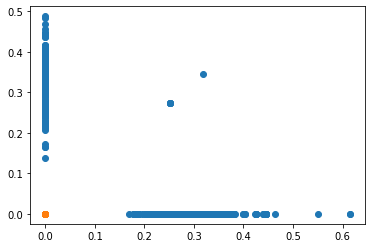

CPU times: user 647 ms, sys: 110 ms, total: 757 ms
Wall time: 772 ms


In [10]:
%%time

# Fit Cluster
clu = AgglomerativeClustering(n_clusters = 2)
# Predict clusters labels
y_pred = clu.fit_predict(tfidf_df)
# Retrieve unique clusters
clusters = np.unique(y_pred)


# Plot the samples from each cluster
for cluster in clusters:
  # Get row indexes for samples with this cluster
  row_ix = np.where(y_pred == cluster)
  # Create scatter of these samples
  plt.scatter(np.array(tfidf_df)[row_ix, 0], np.array(tfidf_df)[row_ix, 1])
# Show the plot
plt.show()


# Collect the measurements
# Silhouette Coefficient
Agg_silhouette = silhouette_score(tfidf_df, y_pred)
# Calinski Harabasz Index
Agg_CalinskiH = calinski_harabasz_score(tfidf_df, y_pred)
# Davies Bouldin Index
Agg_DaviesB = davies_bouldin_score(tfidf_df, y_pred)

#### DBSCAN Clustering

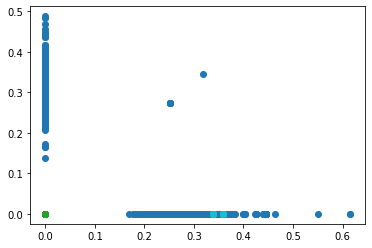

In [12]:
%%time

# Fit Cluster
clu = DBSCAN(eps = 0.30, min_samples = 9)
# Predict clusters labels
y_pred = clu.fit_predict(tfidf_df)
# Retrieve unique clusters
clusters = np.unique(y_pred)


# Collect the measurements
# Silhouette Coefficient
DBS_silhouette = silhouette_score(tfidf_df, y_pred)
# Calinski Harabasz Index
DBS_CalinskiH = calinski_harabasz_score(tfidf_df, y_pred)
# Davies Bouldin Index
DBS_DaviesB = davies_bouldin_score(tfidf_df, y_pred)


# Plot the samples from each cluster
for cluster in clusters:
  # Get row indexes for samples with this cluster
  row_ix = np.where(y_pred == cluster)
  # Create scatter of these samples
  plt.scatter(np.array(tfidf_df)[row_ix, 0], np.array(tfidf_df)[row_ix, 1])
# Show the plot
plt.show()

#### K-Means Clustering    
   
K-Means is extremely sensitive to cluster center initializations. Note that a bad initialization can lead to poor convergence speed and bad overall clustering. To get good results for K-means algorithm corresponding to global minimum. Run the algorithm for different centroid initialization to find out the optimal number of clusters.     

Mini-Batch K-Means is a modified version of K-means that updates to the cluster centroids using mini-batches of samples rather than the entire dataset, which can make it faster for large datasets, and perhaps more robust to statistical noise.  
    
Our dataset is classifying the genuine and mis_informed data so that I set the cluster to 2.

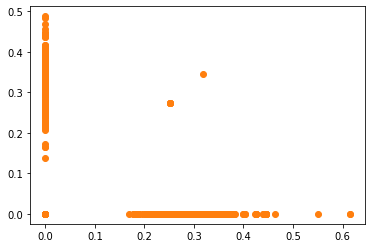

CPU times: user 664 ms, sys: 26 ms, total: 690 ms
Wall time: 689 ms


In [28]:
%%time

# Fit Cluster
clu = KMeans(n_clusters = 2, random_state = 13)
# Predict clusters
y_pred = clu.fit_predict(tfidf_df)
# Retrieve unique clusters
clusters = np.unique(y_pred)


# Collect the measurements
# Silhouette Coefficient
KM_silhouette = silhouette_score(tfidf_df, y_pred)
# Calinski Harabasz Index
KM_CalinskiH = calinski_harabasz_score(tfidf_df, y_pred)
# Davies Bouldin Index
KM_DaviesB = davies_bouldin_score(tfidf_df, y_pred)


# Plot the samples from each cluster
for cluster in clusters:
  # Get row indexes for samples with this cluster
  row_ix = np.where(y_pred == cluster)
  # Create scatter of these samples
  plt.scatter(np.array(tfidf_df)[row_ix, 0], np.array(tfidf_df)[row_ix, 1])
# Show the plot
plt.show()

Reference:      
  
https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c  
https://rocketloop.de/en/machine-learning-clustering-in-python/

### 2) Evaluation    

The Silhouette Coefficient is a measure for each sample and is composed of two scores. The mean distance between a sample and all other points from the same cluster, and from a sample to all other points of different cluster. A **higher** average Silhouette Coefficient Score relates to a better clustering quality.     
  
The Calinski-Harabasz Index correlates with the separation and compactness of the clusters. Hence, the variance of the sums of squares of the distances of individual objects to their cluster center is divided by the sum of squares of the distance between the cluster centers and the center of the data of a cluster. A good clustering result has a **higher** Calinski-Harabasz Index value.     

The Davies-Bouldin Index signifies the average similarity between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. A **lower** Davies-Bouldin Index relates to a model with better separation between the clusters.     

In [39]:
# A table of 3 Clustering Measures with 3 clustering methods
ClusMeasures = pd.DataFrame(np.array([[Agg_silhouette, Agg_CalinskiH, 
                                       Agg_DaviesB],
                                      [DBS_silhouette, DBS_CalinskiH, 
                                       DBS_DaviesB],
                                      [KM_silhouette , KM_CalinskiH , 
                                       KM_DaviesB]]),
            columns = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
            index = ['Agglomerative', 'DBSCAN', 'K-Means'])
ClusMeasures

,Silhouette,Calinski-Harabasz,Davies-Bouldin
Agglomerative,0.010700,391.268131,1.008498
DBSCAN,0.101197,30.467119,1.004384
K-Means,0.010200,367.748439,1.833399


- The average Silhouette Coefficient in DBSCAN is the highest but the Calinski Harabasz Index is extremely low of which is not we prefer. Thus, I think the **Agglomerative Clustering** has overall a better performance for this data. Which has the highest Calinski Harabasz Index and its Silhouette Coefficient and Davies Bouldin Index are not too low (2nd place and not to less than the 1st place). I would like to use Agglomerative as my **TClus**.

Reference:      
     
Silhouette Coefficient https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html  
Calinski Harabasz https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
Davies Bouldin https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html

## UMAP

- The UMAP method can apply dimension reduction to reduce the matrix from 6879 observations by 2000 dimensions to 6879 by 2 (2 is the number of components). Here we use a distance metric of `Hellinger distance` which measures the similarity between 2 probability distributions.   
   
- I plot 2 UMAP, the first one is a bigger subset data, is is very hard to see the classes distribution with these similar color and small dots. While the seconde UMP contains relatively smaller subset data. It is clear to find that the class 0 of genuine and class 1 of mix_misinformed are overlapping together and the amount of class 1 is a lot less than class 0.  

Original tfidf:  (66879, 2000)
tfidf tfidf word embedding:  (66879, 2)
AxesSubplot(0.125,0.125;0.775x0.755)
CPU times: user 26min 4s, sys: 10min 41s, total: 36min 45s
Wall time: 2min 35s


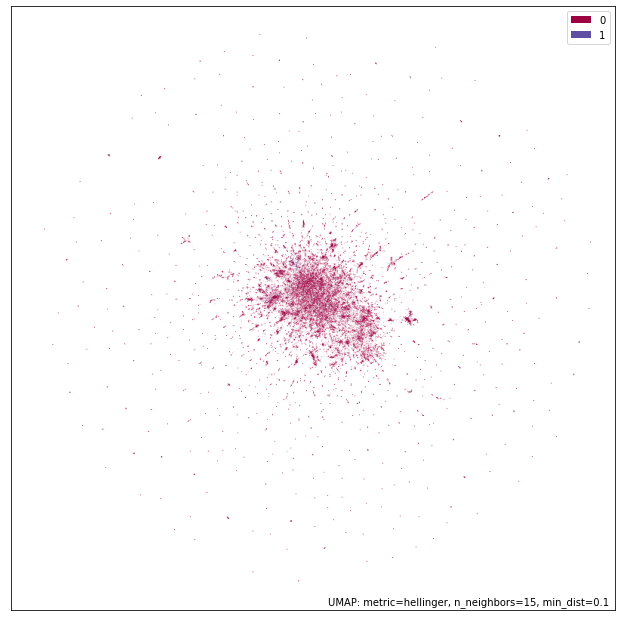

In [10]:
%%time
#
# Shape of tfidf vector
print("Original tfidf: ", tfidf_df.shape)

tfidf_embedding = umap.UMAP(metric='hellinger').fit(tfidf_df)
# Use Hellinger distance and UMAP to embed the documents
print("tfidf tfidf word embedding: ", tfidf_embedding.embedding_.shape)

# Plot the UMAP
fig = umap.plot.points(tfidf_embedding, labels = S_set['labels'])
print(fig)

Original tfidf:  (46879, 2000)
tfidf tfidf word embedding:  (46879, 2)
AxesSubplot(0.125,0.125;0.775x0.755)
CPU times: user 14min 32s, sys: 1min 52s, total: 16min 24s
Wall time: 1min 40s


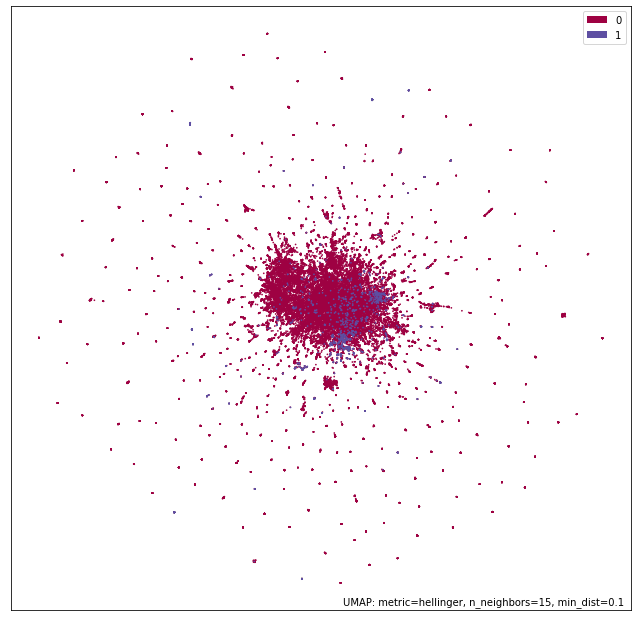

In [6]:
%%time

# Shape of tfidf vector
print("Original tfidf: ", tfidf_df.shape)

tfidf_embedding = umap.UMAP(metric='hellinger').fit(tfidf_df)
# Use Hellinger distance and UMAP to embed the documents
print("tfidf tfidf word embedding: ", tfidf_embedding.embedding_.shape)

# Plot the UMAP
fig = umap.plot.points(tfidf_embedding, labels = S_set['labels'])
print(fig)

Reference:  
  
https://umap-learn.readthedocs.io/en/latest/document_embedding.html

# Part II

- According to the `Part I`, I would like to these methods for `Part II` analysis:   
  - **TClass: Boosting**  
  - **TClus: Agglomerative**  

- Use `TClus` to select the `Probably_Genuine` tweets

### Use `TClus` to select the `Probably_Genuine` tweets  
  
- As known that the last 1612 tweets are the `Mix_misinformed` data. I tried three sizes of dataset to train the clustering method. Which are 46879, 6879, and 3279 tweets in separate. All of them include the whole 1612 `Mix_misinformed` data.  
  
- As we assumed the `Mix_misinformed` data contains Genuine tweets more than Misinformed tweets. My goal is to increase the correct predictions in `Mix_misinformed` and decrease the incorrect prediction in `Genuine`.   
  
- Therefore, to look at the accuracy rate for the whole `y_pred` is not helpful. I will focus on the accuracy rate in the last 1612 `Mix_misinformed` data.

#### 1) Big size (46879 observations)  
  
- This method includes a larger amount of Genuine data. However, the accuracy rate in predicting the `Misinformed` class is very weak. There is 0 observation is correctly predicted to be `Misinformed` in the last 1612 observations.

In [226]:
%%time

# TF-IDF ===============================================
tfidf_vec = TfidfVectorizer(max_df = 0.80, min_df = 5, max_features = 2000) 
tfidf_array = tfidf_vec.fit_transform(S['texts'])
tfidf_df1 = pd.DataFrame(tfidf_array.toarray())

# Obtain a subset TF-IDF vector & S set
tfidf_df1 = tfidf_df1.iloc[80000:, :].reset_index(drop = True)
S1 = S.iloc[80000:].reset_index(drop = True)
# Review the shape of TF-IDF vector & Labels
print(tfidf_df1.shape, S1.labels.shape)
print('The S set dataset is trimmed to', S1.shape)

# Fit Cluster ===========================================
clu = AgglomerativeClustering(n_clusters = 2)
# Predict clusters labels
y_pred1 = clu.fit_predict(tfidf_df1)

(46879, 2000) (46879,)
The S set dataset is trimmed to (46879, 4)
CPU times: user 37min 20s, sys: 10.5 s, total: 37min 31s
Wall time: 37min 31s


- Although the accuracy rate for the whole `y_pred1` is 95%. When I filter to the last 1612 observations (Mix_misinformed), this is a bad prediction with 0 correct prediction in Mix_misinformed data.

In [154]:
# Accuracy Rate
print(np.mean(y_pred1 == S1.labels))
# Filter to the last 1612 Mix_misinformed data
# We assumed to find class = 1 in the last 1612 data
print('The correct prediction in Mix_misinformed data:', 
      sum(y_pred1[45267:] == 1)/sum(S1.labels[45267:] == 1))

0.9571236587811174
The correct prediction in Mix_misinformed data: 0.0


#### 2) Median size (6879 observations)

In [120]:
%%time

# TF-IDF ===============================================
tfidf_vec = TfidfVectorizer(max_df = 0.80, min_df = 5, max_features = 2000) 
tfidf_array = tfidf_vec.fit_transform(S['texts'])
tfidf_df2 = pd.DataFrame(tfidf_array.toarray())

# Obtain a subset TF-IDF vector & S set
tfidf_df2 = tfidf_df2.iloc[120000:, :].reset_index(drop = True)
S2 = S.iloc[120000:].reset_index(drop = True)
# Review the shape of TF-IDF vector & Labels
print(tfidf_df2.shape, S2.labels.shape)
print('The S set dataset is trimmed to', S2.shape)

# Fit Cluster ===========================================
clu = AgglomerativeClustering(n_clusters = 2)
# Predict clusters labels
y_pred2 = clu.fit_predict(tfidf_df2)

(6879, 2000) (6879,)
The S set dataset is trimmed to (6879, 4)
CPU times: user 48.3 s, sys: 46.5 ms, total: 48.3 s
Wall time: 48.3 s


- The correction prediction in Mix_misinformed data is 0.3926. This result is preferable cause we got some correct prediction in Mix_informed class with more predictions in Genuine Class.

In [156]:
# Accuracy Rate
print(np.mean(y_pred2 == S2.labels))
# Filter to the last 1612 Mix_misinformed data
print('The correct prediction in Mix_misinformed data:', 
      sum(y_pred2[5267:] == 1)/sum(S2.labels[5267:] == 1))

0.8412559965111208
The correct prediction in Mix_misinformed data: 0.3926799007444169


#### 3) Small size (3279 observations)

In [124]:
%%time

# TF-IDF ===========================================
tfidf_vec = TfidfVectorizer(max_df = 0.80, min_df = 5, max_features = 2000) 
tfidf_array = tfidf_vec.fit_transform(S['texts'])
tfidf_df3 = pd.DataFrame(tfidf_array.toarray())

# Obtain a subset TF-IDF vector & S set
tfidf_df3 = tfidf_df3.iloc[123600:, :].reset_index(drop = True)
S3 = S.iloc[123600:].reset_index(drop = True)
# Review the shape of TF-IDF vector & Labels
print(tfidf_df3.shape, S3.labels.shape)
print('The S set dataset is trimmed to', S3.shape)

# Fit Cluster ===========================================
clu = AgglomerativeClustering(n_clusters = 2)
# Predict clusters labels
y_pred3 = clu.fit_predict(tfidf_df3)

(3279, 2000) (3279,)
The S set dataset is trimmed to (3279, 4)
CPU times: user 11.2 s, sys: 40.1 ms, total: 11.2 s
Wall time: 11.2 s


- The correct prediction in Mix_misinformed data is 60%. Our assumption is having more Genuine class than Misinformed class in the Mix_misinformed data. Therefore, I think this is not a good prediction either.

In [153]:
# Accuracy Rate
print(np.mean(y_pred3 == S3.labels))
# Filter to the last 1612 Mix_misinformed data
print('The correct prediction in Mix_misinformed data:', 
      sum(y_pred3[1667:] == 1)/sum(S3.labels[1667:] == 1))

0.3043610856968588
The correct prediction in Mix_misinformed data: 0.6066997518610422


### Modify S set data by merging the `Probably_Genuine` data  
  
- Remain the last 1612 `Mix_mininformed` observations with the predicted data.

In [171]:
# Set the Genuine part as class 0
y_pred2[:5267] = 0
# All Genuine observations are class 0
sum(y_pred2[:5267] == 0)
# Merge the y_pred2 to the S set
S2['Probably_Genuine'] = y_pred2

### Run `TClass` on S set  
  
- The F1-Measure is 0.865, which is relatively lower than the previous Boosting method. Besides, the precision and recall are both around 0.86. Although this is not the best, but I personally think this is not too bad.

In [179]:
%%time 

print("Shape of tfidf_df: ", tfidf_df.shape)

# Stratified K-fold CV
SKfold = StratifiedKFold(n_splits = 10, random_state = 29, shuffle = True)

# Fit Boosting
clf = AdaBoostClassifier(random_state = 1)

# Evaluation
S2_precision = cross_val_score(clf, tfidf_df, S2.Probably_Genuine, 
                               cv = SKfold, scoring = 'precision')
S2_recall = cross_val_score(clf, tfidf_df, S2.Probably_Genuine, 
                            cv = SKfold, scoring = 'recall')
S2_f1 = cross_val_score(clf, tfidf_df, S2.Probably_Genuine, 
                        cv = SKfold, scoring = 'f1')
S2_acc = cross_val_score(clf, tfidf_df, S2.Probably_Genuine, 
                         cv = SKfold, scoring = 'accuracy')

# Print the results
print(f'Precision: {np.mean(S2_precision)}')
print(f'Recall: {np.mean(S2_recall)}')
print(f'F-Measure: {np.mean(S2_f1)}')
print(f'Accuracy: {np.mean(S2_acc)}')

Shape of tfidf_df:  (6879, 2000)
Precision: 0.8720214231689216
Recall: 0.8612599206349205
F-Measure: 0.8654749786547093
Accuracy: 0.9754322382451507
CPU times: user 3min 49s, sys: 1.71 s, total: 3min 51s
Wall time: 3min 51s


### Return the tweets contained the Misinformed class.

In [209]:
misinfID = S2[S2.Probably_Genuine == 1][['id', 
                                         'texts', 
                                         'source.text']].reset_index(drop = True)

- Export the Misinformed data that I defined to .txt file. Since I am not sure if we should include the text. Here are two version of data, one is the .txt file with `ID` only, while the other .csv includes the `ID`, `source.text`, and `texts`.

In [210]:
# Save the ID only to .txt
misinfID['id'].to_csv(r'/content/drive/My Drive/Colab Notebooks/ML_DataMining/HW2/misinfID.txt',
                      header=None, index=None, sep='\n')

In [211]:
# Save the ID and the texts to .csv
misinfID.to_csv(r'/content/drive/My Drive/Colab Notebooks/ML_DataMining/HW2/misinfID.csv',
                index = None)

- Read the data to confirm I did sucessfully export the data.

In [216]:
# Read 
misinfID_only_p = '/content/drive/My Drive/Colab Notebooks/ML_DataMining/HW2/misinfID.txt'
misinfID_full_p = '/content/drive/My Drive/Colab Notebooks/ML_DataMining/HW2/misinfID.csv'
misinfID_only = pd.read_csv(misinfID_only_p, header = None)
misinfID_full = pd.read_csv(misinfID_full_p)

In [218]:
misinfID_only.head()  # Misinformed ID

,0
0,1235352692769402882
1,1235314459935203328
2,1234856054812487680
3,1230127357702242309
4,1238127569343401987


In [219]:
misinfID_full.head()  # Misinformed ID with texts

,id,texts,source.text
0,1235352692769402882,coronavirus misinformation spreading fast fake...,Coronavirus misinformation spreading fast: Fak...
1,1235314459935203328,rt coronavirus misinformation spreading fast f...,RT @ResearchBuzz: Coronavirus misinformation s...
2,1234856054812487680,covid19 challenge areal take precaution aware ...,"COVID-19 challenge 'real,' take precautions an..."
3,1230127357702242309,rt vancouver lot misinformation anxiety around...,"RT @tingdan: Here in Vancouver, there is a lot..."
4,1238127569343401987,rt hey figured way report fake news yet would ...,RT @mxpc_: Hey @Twitter have we figured out a ...
